In [54]:
import torch, torchdata, torchtext
from torch import nn

import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234 #3 or 5 times - average results
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


In [55]:
torch.__version__, torchdata.__version__, torchtext.__version__

('2.1.2+cu121', '0.7.1', '0.16.2+cpu')

In [56]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060 Laptop GPU'

### 1. ETL

In [57]:
from torchtext.datasets import AG_NEWS
train, test = AG_NEWS()

In [58]:
train

ShardingFilterIterDataPipe

### 2. EDA

In [59]:
#let's change the unique label
set([y for y, x in list(iter(train))])
#{“World”, “Sports”, “Business”, “Sci/Tech”}

{1, 2, 3, 4}

In [60]:
train_size = len(list(iter(train)))
train_size

120000

In [61]:
too_much, train, valid = train.random_split(total_length=train_size, 
                                            weights = {"too_much": 0.7, "smaller_train": 0.2, 
                                                       "valid": 0.1}, seed=999)

In [62]:
train_size = len(list(iter(train)))
train_size

24000

In [63]:
val_size = len(list(iter(valid)))
val_size

12000

In [64]:
test_size = len(list(iter(test)))
test_size

7600

### 3. Preprocessing

In [65]:
#pip install spacy
#python3 -m spacy download en_core_web_sm
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
tokens = tokenizer("We are learning torchtext in AIT!")  #some test
tokens

['We', 'are', 'learning', 'torchtext', 'in', 'AIT', '!']

In [66]:
from torchtext.vocab import build_vocab_from_iterator
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train), specials=['<unk>', '<pad>', '<bos>', '<eos>'])
vocab.set_default_index(vocab["<unk>"])

In [67]:
#see some example
vocab(['here', 'is', 'a', 'unknownword', 'a'])

[509, 27, 9, 0, 9]

In [68]:
#we can reverse it....
mapping = vocab.get_itos()

#print 159, for example
mapping[509]

'here'

In [69]:
#let's try unknown vocab
vocab(['dddd', 'aaaa'])
#they will all map to <unk> which has 0 as integer

[0, 0]

In [70]:
#let's try special symbols
vocab(['<pad>', '<bos>', '<eos>'])

[1, 2, 3]

In [71]:
#so we can 50k+ unique vocabularies!
len(vocab)

52828

### 4. FastText Embeddings

In [72]:
from torchtext.vocab import FastText
fast_vectors = FastText(language='simple') #small for easy training

In [73]:
fast_embedding = fast_vectors.get_vecs_by_tokens(vocab.get_itos()).to(device)
# vocab.get_itos() returns a list of strings (tokens), where the token at the i'th position is what you get from doing vocab[token]
# get_vecs_by_tokens gets the pre-trained vector for each string when given a list of strings
# therefore pretrained_embedding is a fully "aligned" embedding matrix

In [74]:
fast_embedding.shape   #we have X vocabs, each with a 300 fasttext embedding

torch.Size([52828, 300])

### 5. DataLoader

In [75]:
text_pipeline  = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1 #turn {1, 2, 3, 4} to {0, 1, 2, 3} for pytorch training 

In [76]:
text_pipeline("I love to play football")

[275, 4021, 8, 389, 574]

In [77]:
label_pipeline('1')

0

In [78]:
from torch.utils.data   import DataLoader
from torch.nn.utils.rnn import pad_sequence

pad_idx = vocab['<pad>'] 

def collate_batch(batch):
    label_list, text_list = [], []
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
    #criterion expects float labels
    return torch.tensor(label_list, dtype=torch.int64), pad_sequence(text_list, padding_value=pad_idx, batch_first=True)

In [79]:
batch_size = 64

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True,  collate_fn=collate_batch)
valid_loader = DataLoader(valid, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(test,  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

In [80]:
for label, text in train_loader:
    break

In [81]:
print("Label shape: ", label.shape) # (batch_size, )
print("Text shape: ", text.shape)   # (batch_size, seq len)

Label shape:  torch.Size([64])
Text shape:  torch.Size([64, 141])


### 6. Design the model

In [82]:
import torch.nn as nn
import torch.nn.functional as F

filter_sizes = [3, 4, 5]

class CNN(nn.Module):

    def __init__(self, input_dim, emb_dim, output_dim, dropout, n_filters, filter_sizes):

        super(CNN, self).__init__()

        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_idx)

        self.conv_0    = nn.Conv2d(in_channels=1, out_channels=n_filters, 
                                   kernel_size=(filter_sizes[0], emb_dim))

        self.conv_1    = nn.Conv2d(in_channels=1, out_channels=n_filters, 
                                kernel_size=(filter_sizes[1], emb_dim))
        
        self.conv_2    = nn.Conv2d(in_channels=1, out_channels=n_filters, 
                                kernel_size=(filter_sizes[2], emb_dim))
        
        self.fc        = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout   = nn.Dropout(dropout)

# before squeeze:  torch.Size([64, 100, 139, 1])
# after squeeze:  torch.Size([64, 100, 139])
# max pool before squeeze:  torch.Size([64, 100, 1])
# max pool after squeeze:  torch.Size([64, 100])
# cat:  torch.Size([64, 300])

    def forward(self, text):
        # 1. embed
        #text = [batch_size, seq len]

        embedded = self.embedding(text) #embedded = [batch_size, seq_len, emb_dim]
        embedded = embedded.unsqueeze(1) #embedded = [batch_size, 1, seq_len, emb_dim]

        # 2. convolute

        conved_0  = F.relu(self.conv_0(embedded))

        print('before squeeze: ', conved_0.shape)


        conved_0  = conved_0. squeeze(3)
        conved_1  = F.relu(self.conv_1(embedded). squeeze(3))
        conved_2  = F.relu(self.conv_2(embedded). squeeze(3))

        print('after squeeze: ', conved_0.shape)

        #before squeeze = conved0_n = [batch_size, n_filters, seq_len - filter_size[n] + 1, 1]
        #after squeeze = conved0_n = [batch_size, n_filters, seq_len - filter_size[n] + 1]

        # 3. maxpool
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2])

        print('max pool before squeeze: ', pooled_0.shape)

        pooled_0 = pooled_0.squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)


        print('max pool after squeeze: ', pooled_0.shape)

        #before squeeze = [batch_size, n_filters, 1]
        #after  squeeze = [batch_size, n_filters]

        # 4. dropout and fc
        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim = 1))

        print('cat: ', cat.shape)

        return self.fc(cat)

In [83]:
batch_size, seq_len = 64, 456
input_dim = len(vocab)
input_test = torch.randint(1, input_dim, (batch_size, seq_len))
input_test.shape, input_test.max()

(torch.Size([64, 456]), tensor(52826))

In [84]:
embed = nn.Embedding(input_dim, 300)
embed

Embedding(52828, 300)

In [85]:
embedded = embed(input_test)
embedded.shape

torch.Size([64, 456, 300])

In [86]:
embedded = embedded.unsqueeze(1)
embedded.shape

torch.Size([64, 1, 456, 300])

In [87]:
n_filters    = 100
filter_sizes = [3,4,5]
emb_dim      = 300

conv_0 = nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(filter_sizes[0], emb_dim))

In [88]:
conved_0 = F.relu(conv_0(embedded).squeeze(3))

In [89]:
conved_0.shape

torch.Size([64, 100, 454])

In [119]:
# F.max_pool1d (input, kernel_size)

pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2])
pooled_0.shape

torch.Size([64, 100, 1])

In [121]:
conved_0.shape

torch.Size([64, 100, 454])

In [120]:
conved_0.shape[2]

454

In [ ]:
pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)

In [91]:
pooled_0.shape

torch.Size([64, 100])

In [92]:
a = torch.cat((pooled_0, pooled_0, pooled_0), dim=1)

In [93]:
a.shape

torch.Size([64, 300])

#### nn.ModuleList

In [94]:
# class CNN(nn.Module): #more elegant version
#     def __init__(self, input_dim, emb_dim, output_dim, dropout, n_filters, filter_sizes):
        
#         super().__init__()
                
#         self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_idx)
#         self.convs = nn.ModuleList([
#                                     nn.Conv2d(in_channels = 1, 
#                                               out_channels = n_filters, 
#                                               kernel_size = (fs, emb_dim)) 
#                                     for fs in filter_sizes
#                                     ])
        
#         self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
#         self.dropout = nn.Dropout(dropout)
        
#     def forward(self, text):
                
#         #text = [batch size, sent len]
#         embedded = self.embedding(text)
#         #embedded = [batch size, sent len, emb dim]
        
#         embedded = embedded.unsqueeze(1)
#         #embedded = [batch size, 1, sent len, emb dim]
        
#         conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
#         #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
                
#         pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
#         #pooled_n = [batch size, n_filters]
        
#         cat = self.dropout(torch.cat(pooled, dim = 1))
#         #cat = [batch size, n_filters * len(filter_sizes)]
            
#         return self.fc(cat)

#### nn.Conv1d

In [95]:
# class CNN1d(nn.Module):
#     def __init__(self, input_dim, emb_dim, output_dim, dropout, n_filters, filter_sizes):
        
#         super().__init__()
#         self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_idx)
#         self.convs = nn.ModuleList([
#                                     nn.Conv1d(in_channels = emb_dim, 
#                                               out_channels = n_filters, 
#                                               kernel_size = fs)
#                                     for fs in filter_sizes
#                                     ])
#         self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
#         self.dropout = nn.Dropout(dropout)
        
#     def forward(self, text):
#         #text = [batch size, sent len]
#         embedded = self.embedding(text)
                
#         #embedded = [batch size, sent len, emb dim]
#         embedded = embedded.permute(0, 2, 1)
#         #embedded = [batch size, emb dim, sent len]
        
#         conved = [F.relu(conv(embedded)) for conv in self.convs]
#         #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        
#         pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
#         #pooled_n = [batch size, n_filters]
        
#         cat = self.dropout(torch.cat(pooled, dim = 1))
#         #cat = [batch size, n_filters * len(filter_sizes)]
            
#         return self.fc(cat)

### 7. Training

In [96]:
#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, (nn.Conv2d, nn.Conv2d)):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.kaiming_normal_(param) 

In [97]:
w = torch.empty(3, 5)
x = nn.init.kaiming_normal_(w)
y = nn.init.xavier_normal_(w)
z = nn.init.orthogonal_(w)

print('w: ', w)
print(x)
print(y)
print(z)


w:  tensor([[ 0.0213,  0.4250,  0.3054,  0.8509,  0.0406],
        [ 0.6809,  0.5046, -0.4328, -0.0998, -0.2908],
        [-0.1506,  0.6629,  0.3603, -0.4769,  0.4250]])
tensor([[ 0.0213,  0.4250,  0.3054,  0.8509,  0.0406],
        [ 0.6809,  0.5046, -0.4328, -0.0998, -0.2908],
        [-0.1506,  0.6629,  0.3603, -0.4769,  0.4250]])
tensor([[ 0.0213,  0.4250,  0.3054,  0.8509,  0.0406],
        [ 0.6809,  0.5046, -0.4328, -0.0998, -0.2908],
        [-0.1506,  0.6629,  0.3603, -0.4769,  0.4250]])
tensor([[ 0.0213,  0.4250,  0.3054,  0.8509,  0.0406],
        [ 0.6809,  0.5046, -0.4328, -0.0998, -0.2908],
        [-0.1506,  0.6629,  0.3603, -0.4769,  0.4250]])


In [98]:
input_dim  = len(vocab)
emb_dim    = 300
output_dim = 4 #four classes

#for cnn
dropout = 0.5
n_filters = 100
filter_sizes = [3, 4, 5]

model = CNN(input_dim, emb_dim, output_dim, dropout, n_filters, filter_sizes).to(device)
model.apply(initialize_weights)
model.embedding.weight.data = fast_embedding #**<------applied the fast text embedding as the initial weights

model.to(device)

CNN(
  (embedding): Embedding(52828, 300, padding_idx=1)
  (conv_0): Conv2d(1, 100, kernel_size=(3, 300), stride=(1, 1))
  (conv_1): Conv2d(1, 100, kernel_size=(4, 300), stride=(1, 1))
  (conv_2): Conv2d(1, 100, kernel_size=(5, 300), stride=(1, 1))
  (fc): Linear(in_features=300, out_features=4, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [99]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

15848400
 90000
   100
120000
   100
150000
   100
  1200
     4
______
16209904


In [100]:
import torch.optim as optim

lr=1e-3

#training hyperparameters
optimizer = optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss() #combine softmax with cross entropy

In [101]:
def accuracy(preds, y):
    
    predicted = torch.max(preds.data, 1)[1]
    batch_corr = (predicted == y).sum()
    acc = batch_corr / len(y)
    
    return acc

In [102]:
def train(model, loader, optimizer, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout
    
    for i, (label, text) in enumerate(loader): 
        label = label.to(device) #(batch_size, )
        text = text.to(device) #(batch_size, seq len)
                
        #predict
        predictions = model(text).squeeze(1) #output by the fc is (batch_size, 1), thus need to remove this 1
        
        #calculate loss
        loss = criterion(predictions, label)
        acc  = accuracy(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                        
    return epoch_loss / loader_length, epoch_acc / loader_length

In [103]:
def evaluate(model, loader, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (label, text) in enumerate(loader): 
            label = label.to(device) #(batch_size, )
            text  = text.to(device)  #(seq len, batch_size)

            predictions = model(text).squeeze(1) 
            
            loss = criterion(predictions, label)
            acc  = accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / loader_length, epoch_acc / loader_length

#### putting everything together

In [104]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [105]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [106]:
best_valid_loss = float('inf')
num_epochs      = 2

save_path = f'models/{model.__class__.__name__}.pt'

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, train_loader_length)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

before squeeze:  torch.Size([64, 100, 139, 1])
after squeeze:  torch.Size([64, 100, 139])
max pool before squeeze:  torch.Size([64, 100, 1])
max pool after squeeze:  torch.Size([64, 100])
cat:  torch.Size([64, 300])
before squeeze:  torch.Size([64, 100, 116, 1])
after squeeze:  torch.Size([64, 100, 116])
max pool before squeeze:  torch.Size([64, 100, 1])
max pool after squeeze:  torch.Size([64, 100])
cat:  torch.Size([64, 300])
before squeeze:  torch.Size([64, 100, 83, 1])
after squeeze:  torch.Size([64, 100, 83])
max pool before squeeze:  torch.Size([64, 100, 1])
max pool after squeeze:  torch.Size([64, 100])
cat:  torch.Size([64, 300])
before squeeze:  torch.Size([64, 100, 106, 1])
after squeeze:  torch.Size([64, 100, 106])
max pool before squeeze:  torch.Size([64, 100, 1])
max pool after squeeze:  torch.Size([64, 100])
cat:  torch.Size([64, 300])
before squeeze:  torch.Size([64, 100, 87, 1])
after squeeze:  torch.Size([64, 100, 87])
max pool before squeeze:  torch.Size([64, 100, 1])

Text(0, 0.5, 'loss')

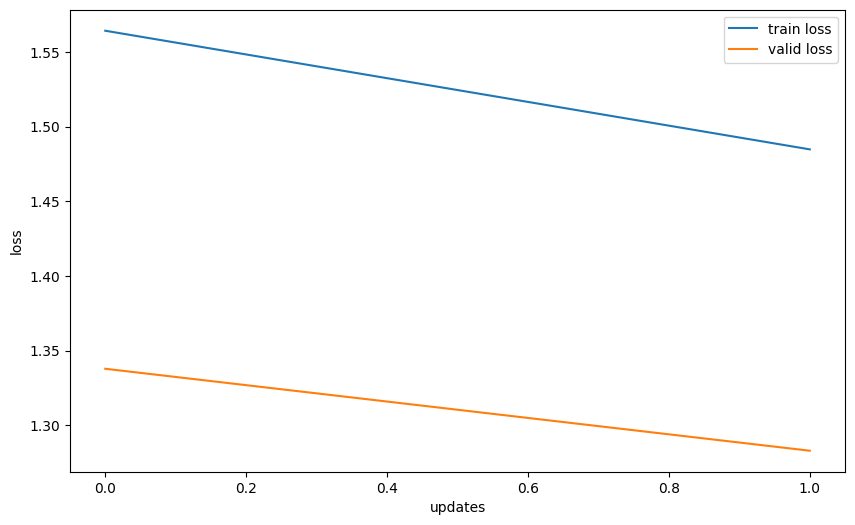

In [107]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

Text(0, 0.5, 'acc')

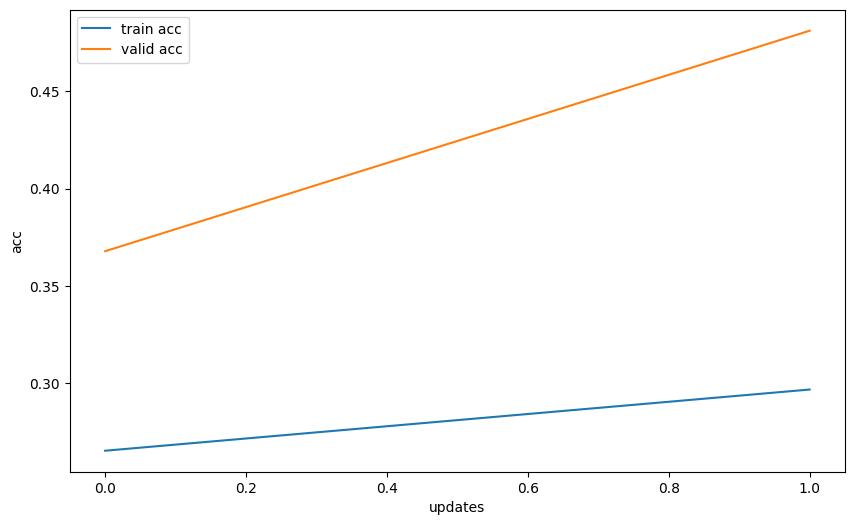

In [108]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')

In [109]:
model.load_state_dict(torch.load(save_path))

test_loss, test_acc = evaluate(model, test_loader, criterion, test_loader_length)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

before squeeze:  torch.Size([64, 100, 157, 1])
after squeeze:  torch.Size([64, 100, 157])
max pool before squeeze:  torch.Size([64, 100, 1])
max pool after squeeze:  torch.Size([64, 100])
cat:  torch.Size([64, 300])
before squeeze:  torch.Size([64, 100, 131, 1])
after squeeze:  torch.Size([64, 100, 131])
max pool before squeeze:  torch.Size([64, 100, 1])
max pool after squeeze:  torch.Size([64, 100])
cat:  torch.Size([64, 300])
before squeeze:  torch.Size([64, 100, 114, 1])
after squeeze:  torch.Size([64, 100, 114])
max pool before squeeze:  torch.Size([64, 100, 1])
max pool after squeeze:  torch.Size([64, 100])
cat:  torch.Size([64, 300])
before squeeze:  torch.Size([64, 100, 96, 1])
after squeeze:  torch.Size([64, 100, 96])
max pool before squeeze:  torch.Size([64, 100, 1])
max pool after squeeze:  torch.Size([64, 100])
cat:  torch.Size([64, 300])
before squeeze:  torch.Size([64, 100, 70, 1])
after squeeze:  torch.Size([64, 100, 70])
max pool before squeeze:  torch.Size([64, 100, 1])

### 8. Test on some random news

In [110]:
test_str = "Google is now falling nonstop.  The price is really bad now."
text = torch.tensor(text_pipeline(test_str)).to(device)
text

tensor([  190,    27,   231,  1742, 14918,     6,    16,    21,   358,    27,
         2561,  1316,   231,     6], device='cuda:0')

In [111]:
text_list = [x.item() for x in text]
text_list

[190, 27, 231, 1742, 14918, 6, 16, 21, 358, 27, 2561, 1316, 231, 6]

In [112]:
[mapping[num] for num in text_list]

['Google',
 'is',
 'now',
 'falling',
 'nonstop',
 '.',
 ' ',
 'The',
 'price',
 'is',
 'really',
 'bad',
 'now',
 '.']

In [113]:
text = text.reshape(1, -1)  #because batch_size is 1

In [114]:
text.shape

torch.Size([1, 14])

In [115]:
def predict(text):
    with torch.no_grad():
        output = model(text).squeeze(1)
        predicted = torch.max(output.data, 1)[1]
        return predicted

In [116]:
predict(text) #0, 1, 2 = technology, 3

before squeeze:  torch.Size([1, 100, 12, 1])
after squeeze:  torch.Size([1, 100, 12])
max pool before squeeze:  torch.Size([1, 100, 1])
max pool after squeeze:  torch.Size([1, 100])
cat:  torch.Size([1, 300])


tensor([2], device='cuda:0')